In [15]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
%matplotlib inline
import tqdm
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions 

from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, callbacks, optimizers
from tensorflow.keras.layers import Layer, Input 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



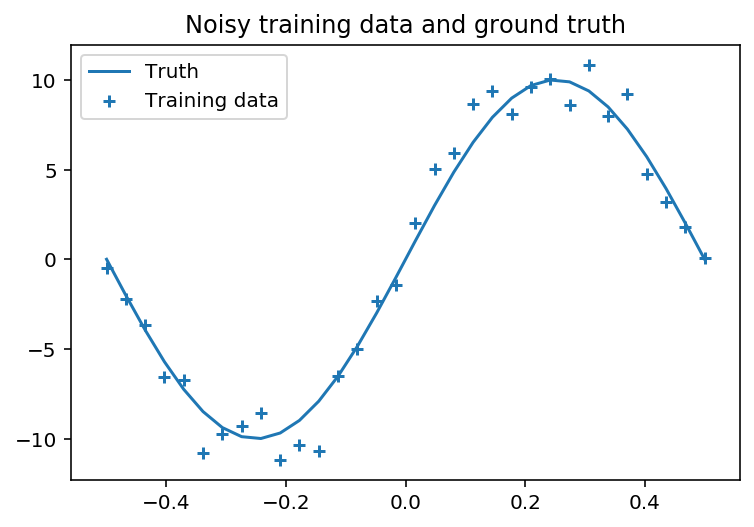

In [2]:
def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10 * np.sin(2 * np.pi * (x)) + epsilon

train_size = 32
noise = 1.0

X = np.linspace(-0.5, 0.5, train_size).reshape(-1,1)
y = f(X, sigma=noise)
y_true = f(X, sigma=0.0)

plt.scatter(X, y, marker='+', label='Training data')
plt.plot(X, y_true, label='Truth')
plt.title('Noisy training data and ground truth')
plt.legend()

In [6]:
def mixture_prior_params(sigma_1, sigma_2, pi, return_sigma=False):
    params = K.variable([sigma_1, sigma_2, pi], name='mixture_prior_params')
    sigma = np.sqrt(pi * sigma_1 ** 2 + (1 - pi) * sigma_2 ** 2)
    return params, sigma

def log_mixture_prior_prob(w):
    comp_1_dist = tf.distributes.Normal(0.0, prior_params[0])
    comp_2_dist = tf.distributes.Normal(0.0, prior_params[1])
    comp_1_weight = prior_params[2]
    return K.log(comp_1_weight * comp_2_dist.prob(w) + (1-comp_1_weight) * comp_2_dist.prob(w))

prior_params, prior_sigma = mixture_prior_params(sigma_1=1.0, sigma_2=0.1, pi=0.2)
    

In [7]:
batch_size = train_size
num_batches = train_size / batch_size
kl_loss_weight = 1.0 / num_batches

In [9]:
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.0))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2*n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n], scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])

def prior_trainble(kernel_size, bias_size=0, dtype=0):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
        tfd.Normal(loc=t, scale=1),
        reinterpreted_batch_ndims=1)),
    ])

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tfp.layers.DenseVariational(units=20, 
                                make_posterior_fn=posterior_mean_field,
                               make_prior_fn=prior_trainble,
                               kl_weight=kl_loss_weight, 
                               activation='relu'),
    tfp.layers.DenseVariational(units=20, 
                                make_posterior_fn=posterior_mean_field,
                               make_prior_fn=prior_trainble,
                               kl_weight=kl_loss_weight, 
                               activation='relu'),
    tfp.layers.DenseVariational(units=1, 
                                make_posterior_fn=posterior_mean_field,
                               make_prior_fn=prior_trainble,
                               kl_weight=kl_loss_weight)
])

In [14]:
def neg_log_likelihood(y_true, y_pred, sigma=noise):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_true))

model.compile(loss=neg_log_likelihood, optimizer=Adam(lr=0.03), metrics=['mse'])
model.fit(X,y, batch_size=batch_size, epochs=1500, verbose=0)

100%|██████████| 500/500 [00:28<00:00, 17.63it/s]


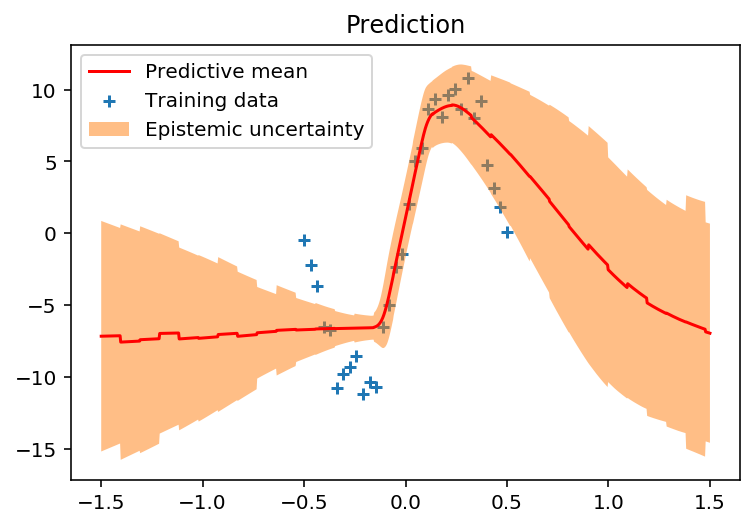

In [16]:
X_test=np.linspace(-1.5, 1.5, 1000).reshape(-1,1)
y_pred_list = []

for i in tqdm.tqdm(range(500)):
    y_pred = model.predict(X_test)
    y_pred_list.append(y_pred)
    
y_preds = np.concatenate(y_pred_list, axis=1)
y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

plt.plot(X_test, y_mean, 'r-', label='Predictive mean')
plt.scatter(X,y, marker='+', label='Training data')
plt.fill_between(X_test.ravel(),
                y_mean + 2 * y_sigma,
                y_mean - 2 * y_sigma,
                alpha=0.5, label='Epistemic uncertainty')
plt.title('Prediction')
plt.legend()